# March 18th, 2021

**Motivation**: Eeffect of bandpassing on community structure.</br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Dirs
base_dir = pjoin(os.environ['HOME'], 'Documents/data')
raw_dir = pjoin(base_dir, 'raw')
processed_dir = pjoin(base_dir, 'processed')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [26]:
# HIDE CODE


def load_data(
    load_dir: str,
    keywords: list = None,
    ca_fs: int = 10,
    run_duration: int = 600,
    exclude: int = 60,
    verbose=False, ):
    
    if keywords is None: keywords = ['ca', 'ses-1', 'sub-SLC06', 'rest']
    filter_fn = lambda x: all(k in x for k in keywords)
    files = sorted(list(filter(filter_fn, os.listdir(load_dir))))
    
    good_timepoints = (run_duration - exclude) * ca_fs

    data_list = []
    for load_filename in files:
        ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
        data_list.append(ca[..., 0, range(ca.shape[-1] - good_timepoints, ca.shape[-1])])
    ca = filter_boundaries(np.concatenate(data_list, axis=-1), dim=2)

    if verbose:
        print("Data from {:d} runs loaded:\n".format(len(files)))
        pprint(files)

        msg = '\n-->  {:d} s  <-- excluded from the beginning of each run. Combined runs duration:'
        msg = msg.format(exclude)
        print(msg)
        convert_time(ca.shape[-1] / ca_fs)

    return ca


def detect_anomalies(
    x: np.ndarray,
    window: int = 50,
    num_stds: int = 7,
    num_filter: int = 5,
    verbose: bool = True, ):
    
    npix_x, npix_y, nt = x.shape
    num = int(np.ceil(nt/window))

    sigma = np.zeros((npix_x, npix_y, num))
    for n in tqdm(range(num), leave=False):
        start = n*window
        end = min(nt, (n+1)*window)
        sigma[..., n] = np.var(x[..., start:end], axis=-1)

    sigma /= sigma.sum(-1, keepdims=True)
    sigma_avg = sigma.mean(-1)
    sigma_std = sigma.std(-1)
    indxs_sorted = np.argsort(sigma, axis=-1)[::-1]

    anomalies = {}
    for i in tqdm(range(npix_x), leave=False):
        for j in range(npix_y):
            _anomalies = []
            for t in indxs_sorted[i, j]:
                if sigma[i, j, t] - sigma_avg[i, j] > num_stds * sigma_std[i, j]:
                    _anomalies.append(t)
            anomalies['{:d},{:d}'.format(i, j)] = _anomalies

    if verbose:
        msg = '{:.0f} {:s} of all pixels contain at least one anomalous time period'
        msg = msg.format(len(list(filter(lambda x: len(x), anomalies.values()))) / (npix_x * npix_y) * 100, '%')
        print(msg)
        
    # put results in a df
    all_indxs = []
    dict_list = []
    for k, v in anomalies.items():
        if len(v):
            all_indxs.extend(v)
            i, j = tuple(map(lambda x: int(x), k.split(',')))
            data_dict = {
                'idx': range(num),
                'ratio': [len(v) / num] * num,
                'sigma': sigma[i, j],
            }
            dict_list.append(data_dict)
    df = pd.DataFrame.from_dict(merge_dicts(dict_list))
    
    most_common = collections.Counter(all_indxs).most_common()[:num_filter]
    filter_indxs = []
    for idx, _ in most_common:
        start = idx*window
        end = min(nt, (idx+1)*window)
        filter_indxs.extend(range(start, end))
    filter_indxs = list(sorted(np.unique(filter_indxs)))

    output = {
        'sigma': sigma,
        'df': df,
        'all_indxs': all_indxs,
        'most_common': most_common,
        'filter_indxs': filter_indxs,
    }
    return output


def filter_boundaries(x, dim: int = 2):
    if dim == 2:
        bad_x_indices = np.where(x.mean(-1).mean(1) == 0)[0]
        bad_y_indices = np.where(x.mean(-1).mean(0) == 0)[0]
        x = np.delete(np.delete(x, bad_y_indices, axis=1), bad_x_indices, axis=0)
    elif dim == 3:
        raise NotImplementedError
    else:
        raise ValueError("wrong dim")
    return x


def filter_islands(partition, labels, scale: int, min_com_size: int = 5):
    coms_ctr = collections.Counter(partition.values())
    good_com_idxs = tuple(zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common())))[0]
    
    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)

    comm_mat = np.ones((scale, scale)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        com_idx = partition[node_idx]
        if com_idx in good_com_idxs:
            comm_mat[i, j] = good_com_idxs.index(com_idx)
        else:
            comm_mat[i, j] = np.nan
    
    return comm_mat, comm_dict


def downsample(x: np.ndarray, size: int = 32):
    if len(x.shape) == 3:  
        npix_x, npix_y, nt = x.shape
        widths = [int(np.ceil(item / size)) for item in [npix_x, npix_y]]

        downsampled = np.zeros((size, size, nt))
        for i in range(size):
            for j in range(size):
                data = x[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
                num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)

                if num_nonzero_mean > 0:
                    downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
                else:
                    downsampled[i, j, :] = 0.
    
    elif len(x.shape) == 4:
        raise NotImplementedError

    else:
        raise ValueError("Only 2 and 3 spatial dims supported.")

    return downsampled


def get_df(x: np.ndarray, filter_idxs=None):
    size_x, size_y, nt = x.shape
    means = abs(x).mean(-1)
    dict_list = []
    for i in tqdm(range(size_x), leave=False):
        for j in range(size_y):
            k = '{:d},{:d}'.format(i, j)

            if means[i, j] != 0:
                data_dict = {
                    'id': [k] * nt,
                    't': np.arange(nt),
                    'val': x[i, j],
                }
                dict_list.append(data_dict)

    df = pd.DataFrame.from_dict(merge_dicts(dict_list))
    df = df.pivot(index='t', columns='id', values='val')
    reindex_fn = lambda x: int(x.split(',')[0]) * 10000 + int(x.split(',')[1])
    df = df.reindex(sorted(df.columns, key=reindex_fn), axis=1)
    
    if filter_idxs is not None:
        df.iloc[filter_idxs] = np.nan
    
    labels = labels = df.columns.values.tolist()
    labels = {i: lbl for i, lbl in enumerate(labels)}
    
    return df, labels


def get_corrs(df: pd.DataFrame, thresholds=None):
    if thresholds is None: thresholds = [0.6, 0.7, 0.75, 0.8, 0.85]
 
    pearson_corr = df.corr('pearson').values
    spearman_corr = df.corr('spearman').values

    np.fill_diagonal(pearson_corr, 0)
    np.fill_diagonal(spearman_corr, 0)

    pearson, spearman = {}, {}
    for th in thresholds:
        pmat = pearson_corr.copy()
        smat = spearman_corr.copy()
        pmat[pmat<th] = 0.
        smat[smat<th] = 0.
        pearson[th] = pmat
        spearman[th] = smat
        
    return pearson, pearson_corr, spearman, spearman_corr



def run_louvain(g, res=np.logspace(-1, 1, 101)):
    # run algorithm
    communities = {}

    for resolution in tqdm(res, leave=False):
        coms = algorithms.louvain(g, resolution=resolution) 
        communities[resolution] = coms.communities

    # process results
    modularities = {}
    num_communities = {}

    for resolution, coms_list in communities.items():
        modularities[resolution] = nx_comm.modularity(g, communities=coms_list)
        num_communities[resolution] = len(coms_list)
        
    return communities, modularities, num_communities



# bandpass

from scipy import signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = signal.lfilter_zi(b, a)
    y, zo = signal.lfilter(b, a, data, zi=zi*data[0])
    return y, zo


def apply_bandpass(
    x: np.ndarray,
    fs: int,
    lowcut: float = 0.01,
    highcut : float = 3.0,
    order: int = 2, ):
 
    x_bp = np.zeros(x.shape)
    for i in tqdm(range(x.shape[0]), leave=False):
        for j in range(x.shape[1]):
            x_bp[i, j], _ = butter_bandpass_filter(
                data=x[i, j],
                lowcut=lowcut,
                highcut=highcut,
                fs=fs,
                order=order,)
    return x_bp



# plots

def plot_downsampled(x):
    sns.set_style('white')

    data = x.mean(-1)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(data, cmap='Greens', interpolation='none')
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.colorbar()
    plt.title('Avg ca responses in ROIs')

    data[np.abs(data)>0] = 1

    plt.subplot(122)
    plt.imshow(data, cmap='Greens', interpolation='none')
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.colorbar()
    plt.title('nonzero ROIs')

    plt.tight_layout()
    plt.show()
    


def plot_corrs(spearman, pearson, thresholds):
    fig, axes = plt.subplots(2, len(thresholds), figsize=(13.5, 5.5))

    for i, th in enumerate(thresholds):
        sns.heatmap(
            spearman[th],
            cmap='nipy_spectral',
            vmin=th,
            vmax=1.,
            cbar_kws={'aspect': 40, 'shrink': 0.8},
            ax=axes[0, i]
        )
        axes[0, i].set_aspect('equal')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        msg = 'threshold = {:.2f}\n\ntop {:.1f}{:s} of corrs'
        msg = msg.format(th, (spearman[th]>0).sum() / len(spearman[th]) ** 2 * 100, '%')
        axes[0, i].set_title(msg, fontsize=13)

        sns.heatmap(
            pearson[th],
            cmap='nipy_spectral',
            vmin=th,
            vmax=1.,
            cbar_kws={'aspect': 40, 'shrink': 0.8},
            ax=axes[1, i]
        )
        axes[1, i].set_aspect('equal')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        msg = 'top {:.1f}{:s} of corrs'
        msg = msg.format((pearson[th]>0).sum() / len(pearson[th]) ** 2 * 100, '%')
        axes[1, i].set_title(msg, fontsize=13)

        if i == 0:
            axes[0, i].set_ylabel('spearman', fontsize=15)
            axes[1, i].set_ylabel('pearson', fontsize=15)

    msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
    fig.suptitle(msg, y=1.03, fontsize=17)
    fig.tight_layout()
    plt.show()
    
    
    
def plot_corr_hist(spearman_corr, pearson_corr):
    xp = np.triu(pearson_corr)
    xs = np.triu(spearman_corr)
    xp = xp.flatten()
    xs = xs.flatten()

    plt.figure(figsize=(8, 5))
    sns.histplot(xp[xp>0.0], kde=True, color='b', alpha=0.25, label='pearson')
    sns.histplot(xs[xs>0.0], kde=True, color='r', alpha=0.25, label='spearman')
    plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
    plt.axvline(xp[xp>0.0].mean(), color='b', ls='--', lw=1.5, label='pearson (mean)')
    plt.axvline(xs[xs>0.0].mean(), color='r', ls='--', lw=1.5, label='spearman (mean)')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

    
    
def plot_louvain_results(modularities, num_communities, selected_idxs):
    palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')

    x0, y0 = tuple(zip(*modularities.items()))
    axes[0].loglog(x0, y0, lw=3)
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    res_at_max_mod = x0[max_mod_idx]
    lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
    axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)

    for i, _idx in enumerate(selected_idxs):
        lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
        axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

    x1, y1 = tuple(zip(*num_communities.items()))
    axes[1].loglog(x1, y1, lw=3)
    lbl = '# comm = {:d}'.format(y1[max_mod_idx])
    axes[1].axvline(res_at_max_mod, color='k', lw=2, ls='--', label=lbl)

    for i, _idx in enumerate(selected_idxs):
        lbl = '# comm = {:d}'.format(y1[_idx])
        axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

    axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
    axes[0].set_xlabel('resolution (log)', fontsize=12)
    axes[0].set_ylabel('Q modularity (log)', fontsize=12)
    axes[0].legend(loc='lower left')

    axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
    axes[1].set_xlabel('resolution (log)', fontsize=12)
    axes[1].set_ylabel('# communities (log)', fontsize=12)
    axes[1].legend(loc='lower left')

    fig.tight_layout()
    plt.show()
    
    

def plot_louvain_communities(
    spearman: dict,
    pearson: dict,
    modularities: dict,
    selected_idxs: list,
    spearman_th: float = 0.75,
    pearson_th: float = 0.8,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [max_mod_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        g = nx.from_numpy_matrix(spearman[0.8])
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[0, ii].imshow(comm_mat, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[0, ii].set_title(msg, y=1.03)

        g = nx.from_numpy_matrix(pearson[0.8])
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[1, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[0, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            axes[1, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()

    
    
def plot_louvain_extended(
    plot_data: dict,
    modularities: dict,
    selected_idxs: list,
    figsize=(10, 9),
    colorbar=False, ):
    
    x0, y0 = tuple(zip(*modularities.items()))
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    plot_idxs = sorted(selected_idxs + [max_mod_idx])
    
    sns.set_style('white')
    
    for mode, corrs in plot_data.items():
        cmap = 'RdYlBu_r' if mode == 'Spearman' else 'Spectral_r'
        fig, axes = plt.subplots(len(thresholds), len(plot_idxs), figsize=figsize)
        for jj, (th, corr) in enumerate(corrs.items()):
            for ii, idx in enumerate(plot_idxs):
                g = nx.from_numpy_matrix(corr)
                partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
                comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
                q = nx_comm.modularity(g, communities=comm_dict.values())

                im = axes[jj, ii].imshow(comm_mat, cmap=cmap, interpolation='none')
                if colorbar:
                    plt.colorbar(im, ax=axes[jj, ii], shrink=0.8)
                axes[jj, ii].set_xticks([])
                axes[jj, ii].set_yticks([])
                
                if jj == 0:
                    msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
                    msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
                else:
                    msg = 'Q = {:.3f},  # com = {:d}'
                    msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
                axes[jj, ii].set_title(msg, fontsize=10, y=1.03)

                if ii == 0:
                    axes[jj, ii].set_ylabel('th = {:.2f}'.format(th), fontsize=13)

        fig.suptitle(mode, fontsize=18, y=1.02)
        fig.tight_layout()
        plt.show()
        
        print('\n\n')
        

        
def plot_leiden(spearman, pearson, colorbar=False):
    thresholds = list(spearman.keys())
    
    sns.set_style('white')
    fig, axes = plt.subplots(len(thresholds), 2, figsize=(6.5, 3*len(thresholds)))

    for ii, th in enumerate(sorted(thresholds, reverse=True)):
        g = nx.from_numpy_matrix(spearman[th])
        coms = algorithms.leiden(g)
        partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[ii, 0].imshow(comm_mat, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'th = {:.2f}\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(th, q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[ii, 0].set_title(msg, y=1.03)

        g = nx.from_numpy_matrix(pearson[th])
        coms = algorithms.leiden(g)
        partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[ii, 1].imshow(comm_mat, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'th = {:.2f}\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(th, q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[ii, 1].set_title(msg, y=1.03)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    

def plot_leiden_extended(
    plot_data: dict,
    thresholds: list,
    lowcuts: list,
    highcuts: list,
    mode: str,
    figsize=None,
    colorbar=False, ):

    assert mode in ['Spearman', 'Pearson'], "invalid mode: {:s}".format(mode)
    cmap = 'RdYlBu_r' if mode == 'Spearman' else 'Spectral_r'
    
    sns.set_style('white')
    nrows = len(thresholds)
    ncols = len(lowcuts) * len(highcuts)
    figsize = (13.5, nrows * 1.4) if figsize is None else figsize
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    for i, lowcut in enumerate(sorted(lowcuts)):
        for j, highcut in enumerate(sorted(highcuts)):
            jj = i * len(highcuts) + j
            for ii, th in enumerate(sorted(thresholds, reverse=True)):
                key = "{:.2f},{:.2f},{:.2f}".format(lowcut, highcut, th)
                corr = plot_data[key]
                
                g = nx.from_numpy_matrix(corr)
                coms = algorithms.leiden(g)
                partition = {n: [n in item for item in coms.communities].index(True) for n in g.nodes()}
                comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
                q = nx_comm.modularity(g, communities=comm_dict.values())

                im = axes[ii, jj].imshow(comm_mat, cmap=cmap, interpolation='none')
                if colorbar:
                    plt.colorbar(im, ax=axes[ii, jj], shrink=0.8)
                axes[ii, jj].set_xticks([])
                axes[ii, jj].set_yticks([])
                
                msg = 'low: {}\nhigh: {}'.format(lowcut, highcut)
                axes[ii, jj].set_title(msg, fontsize=8, y=1.02)
                
                if jj == 0:
                    msg = 'th = {:.2f}'.format(th)
                    axes[ii, jj].set_ylabel(msg, fontsize=8)

    msg = 'Effect of thresholding and bandpassing on community structure.  Frequencies are in Hz\n'
    msg += 'Using {:s} correlation + Leiden algorithm'
    fig.suptitle(msg.format(mode), fontsize=17, y=1.02)
    fig.tight_layout()
    plt.show()

## Closer look at possible data flaws

I choose a dataset that looks OK from subject named **sub-SLC08**.  Then I will describe a systematic way of examining data quality.  I don't think serious flaws such as sudden drastic jumps are that frequent.

In [3]:
# HIDE CODE

run_duration = 600   # 600 seconds
ca_fs = 10
exclude = 60

ca = load_data(
    load_dir=processed_dir,
    keywords=['ca', 'ses-1', 'sub-SLC06', 'rest'],
    ca_fs=ca_fs,
    run_duration=run_duration,
    exclude=exclude,
    verbose=True,
) 

Data from 4 runs loaded:

['sub-SLC06_ses-1_run-1_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-3_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-5_task-rest_ca.npy',
 'sub-SLC06_ses-1_run-7_task-rest_ca.npy']

-->  60 s  <-- excluded from the beginning of each run. Combined runs duration:

00 - 00:36:00  (dd - hh:mm:ss)



In [4]:
npix_x, npix_y, nt = ca.shape
npix_x, npix_y, nt

(190, 186, 21600)

## Detect anomalies

In [5]:
window = 50
num_stds = 5
num_filter = 5

anomalies = detect_anomalies(
    ca,
    window=window,
    num_stds=num_stds,
    num_filter=num_filter,
)

47 % of all pixels contain at least one anomalous time period


## Bandpass (full data) + Comm

In [6]:
order = 2
lowcut, highcut = 0.01, 4.0

ca_bp = apply_bandpass(
    ca,
    fs=ca_fs,
    lowcut=lowcut,
    highcut=highcut,
    order=order,
)
ca_bp.shape

(190, 186, 21600)

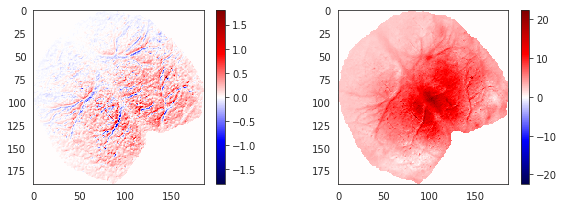

In [7]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
data = ca_bp.mean(-1)
vminmax = np.max(np.abs(data))
plt.imshow(data, cmap='seismic', vmin=-vminmax, vmax=vminmax, interpolation='none')
plt.colorbar()

plt.subplot(122)
data = ca.mean(-1)
vminmax = np.max(np.abs(data))
plt.imshow(data, cmap='seismic', vmin=-vminmax, vmax=vminmax, interpolation='none')
plt.colorbar()

plt.show()

### Downsample

In [8]:
size = 16
downsampled = downsample(ca_bp, size=size)
downsampled.shape

(16, 16, 21600)

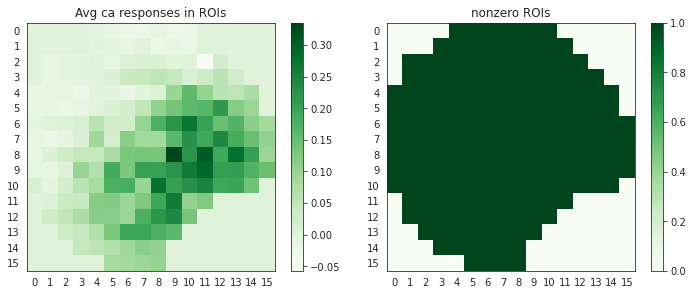

In [9]:
plot_downsampled(downsampled)

In [12]:
thresholds = [0.7, 0.73, 0.75, 0.78, 0.8, 0.82, 0.85]

df, labels = get_df(downsampled, filter_idxs=anomalies['filter_indxs'])
pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)

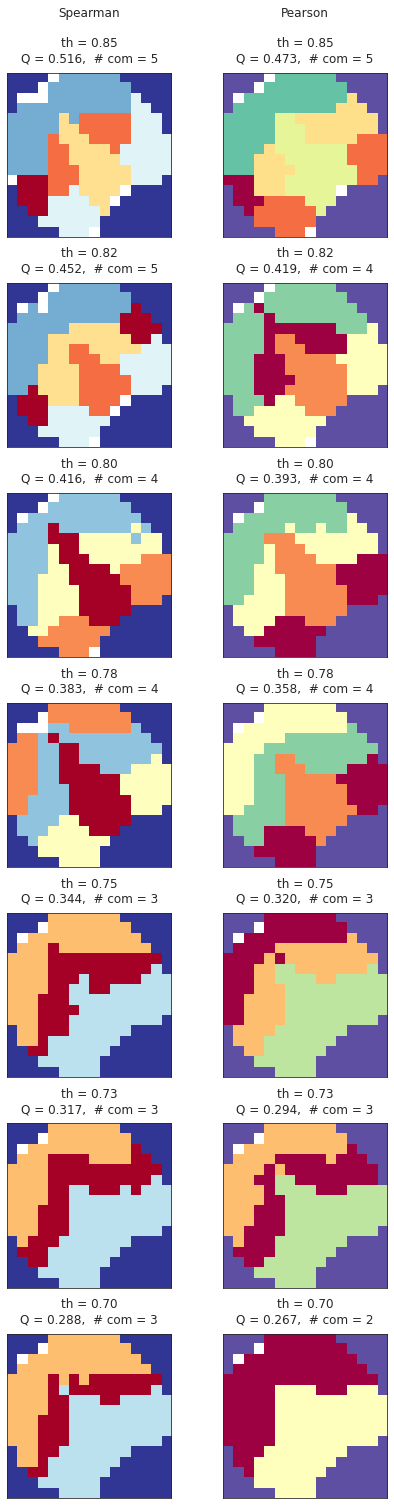

In [13]:
plot_leiden(spearman, pearson)

## Bandpass f, and threshold plot

### scale = 16

In [14]:
size = 16
thresholds = [0.75, 0.78, 0.8, 0.82, 0.85]

order = 2
lf = [0.001, 0.01, 0.04, 0.1]
hf = [1.0, 2.0, 3.0, 4.0]

results_spearman = {}
results_pearson = {}
for lowcut in tqdm(lf):
    for highcut in tqdm(hf, leave=False):
        # apply bandpass
        ca_bp = apply_bandpass(
            ca,
            fs=ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order,
        )
        # downsample
        downsampled = downsample(ca_bp, size=size)
        
        # get df and corrs
        df, labels = get_df(downsampled, filter_idxs=anomalies['filter_indxs'])
        pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)
        
        for th in thresholds:
            key = "{:.2f},{:.2f},{:.2f}".format(lowcut, highcut, th)
            results_spearman[key] = spearman[th]
            results_pearson[key] = pearson[th]

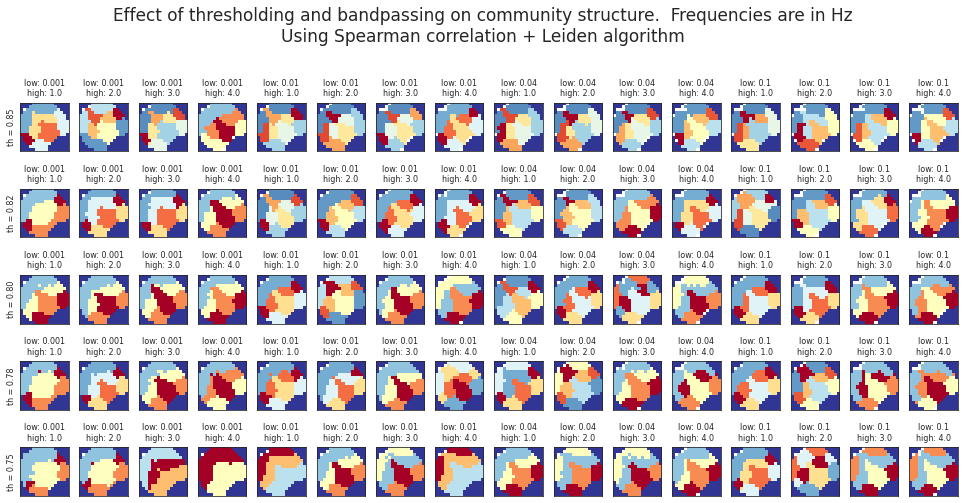

In [24]:
plot_leiden_extended(
    plot_data=results_spearman,
    thresholds=thresholds,
    lowcuts=lf,
    highcuts=hf,
    mode='Spearman',
)

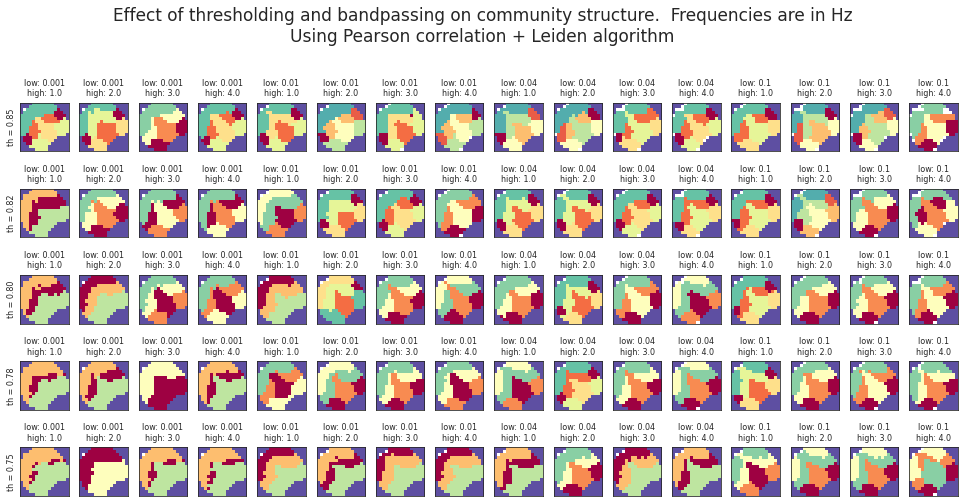

In [25]:
plot_leiden_extended(
    plot_data=results_pearson,
    thresholds=thresholds,
    lowcuts=lf,
    highcuts=hf,
    mode='Pearson',
)

### scale = 32

In [27]:
size = 32
thresholds = [0.75, 0.78, 0.8, 0.82, 0.85]

order = 2
lf = [0.001, 0.01, 0.04, 0.1]
hf = [1.0, 2.0, 3.0, 4.0]

results_spearman = {}
results_pearson = {}
for lowcut in tqdm(lf):
    for highcut in tqdm(hf, leave=False):
        # apply bandpass
        ca_bp = apply_bandpass(
            ca,
            fs=ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order,
        )
        # downsample
        downsampled = downsample(ca_bp, size=size)
        
        # get df and corrs
        df, labels = get_df(downsampled, filter_idxs=anomalies['filter_indxs'])
        pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)
        
        for th in thresholds:
            key = "{:.2f},{:.2f},{:.2f}".format(lowcut, highcut, th)
            results_spearman[key] = spearman[th]
            results_pearson[key] = pearson[th]

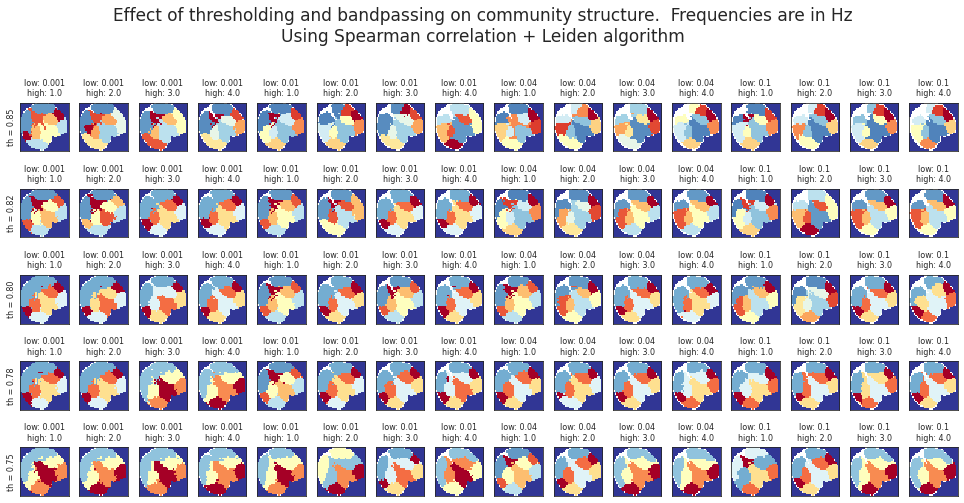

In [28]:
plot_leiden_extended(
    plot_data=results_spearman,
    thresholds=thresholds,
    lowcuts=lf,
    highcuts=hf,
    mode='Spearman',
)

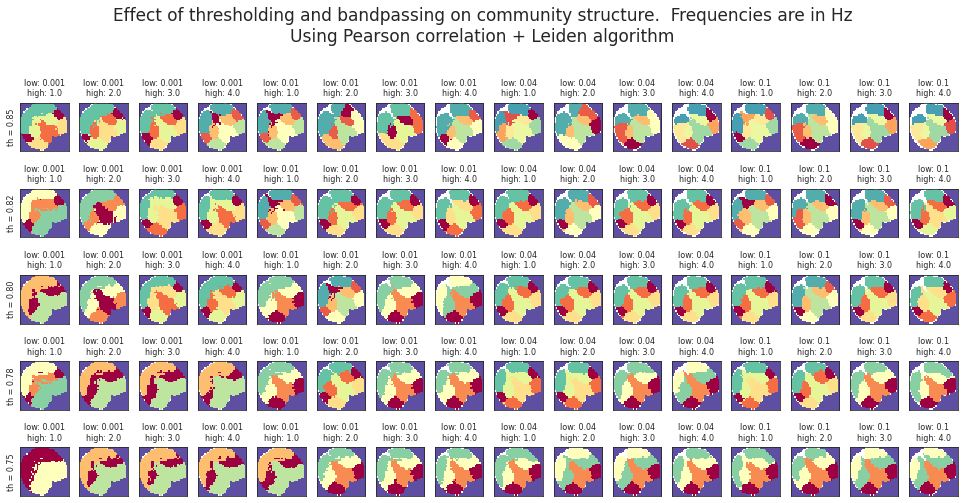

In [29]:
plot_leiden_extended(
    plot_data=results_pearson,
    thresholds=thresholds,
    lowcuts=lf,
    highcuts=hf,
    mode='Pearson',
)

### scale = 64

In [30]:
size = 64
thresholds = [0.75, 0.78, 0.8, 0.82, 0.85]

order = 2
lf = [0.001, 0.01, 0.04, 0.1]
hf = [1.0, 2.0, 3.0, 4.0]

results_spearman = {}
results_pearson = {}
for lowcut in tqdm(lf):
    for highcut in tqdm(hf, leave=False):
        # apply bandpass
        ca_bp = apply_bandpass(
            ca,
            fs=ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order,
        )
        # downsample
        downsampled = downsample(ca_bp, size=size)
        
        # get df and corrs
        df, labels = get_df(downsampled, filter_idxs=anomalies['filter_indxs'])
        pearson, pearson_corr, spearman, spearman_corr = get_corrs(df, thresholds=thresholds)
        
        for th in thresholds:
            key = "{:.2f},{:.2f},{:.2f}".format(lowcut, highcut, th)
            results_spearman[key] = spearman[th]
            results_pearson[key] = pearson[th]

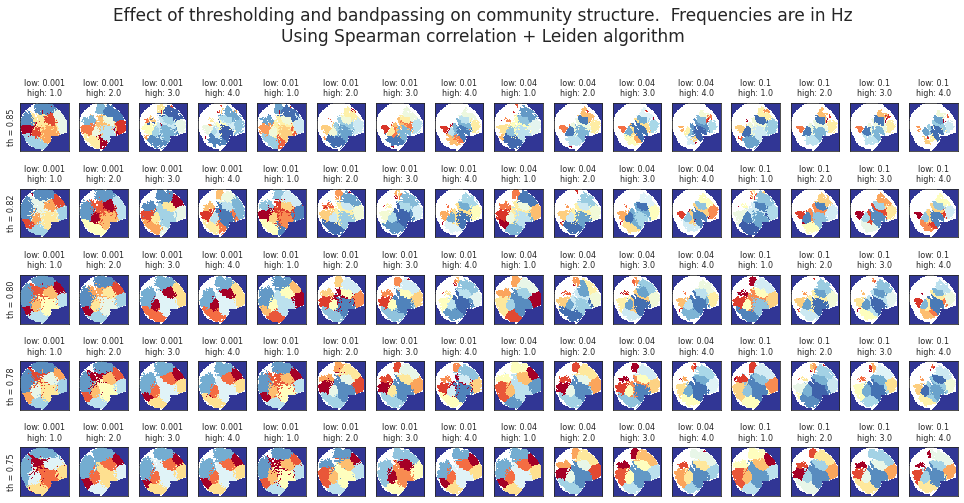

In [31]:
plot_leiden_extended(
    plot_data=results_spearman,
    thresholds=thresho
    
    lds,
    lowcuts=lf,
    highcuts=hf,
    mode='Spearman',
)

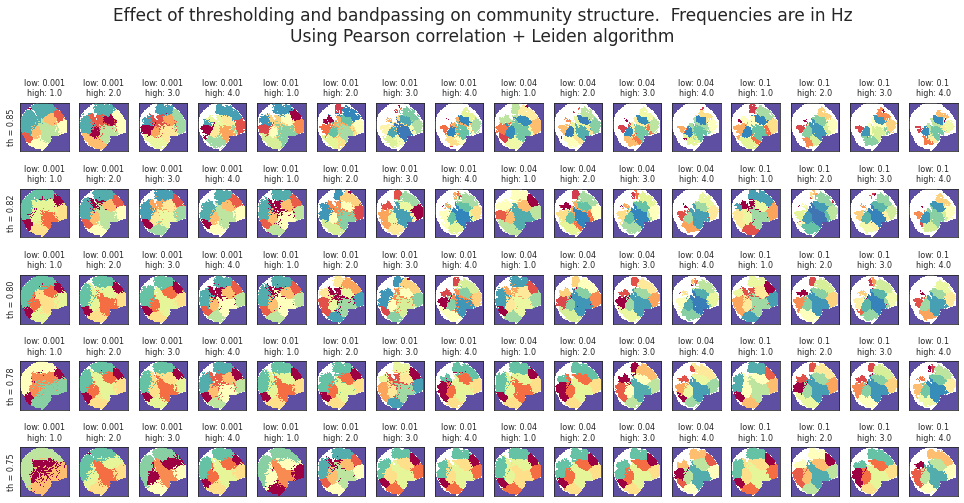

In [32]:
plot_leiden_extended(
    plot_data=results_pearson,
    thresholds=thresholds,
    lowcuts=lf,
    highcuts=hf,
    mode='Pearson',
)